# Config

In [1]:
import pandas as pd
import geopandas as gpd # from pathlib import Path 
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.patches as mpatches


In [2]:
# Read sheets
df = pd.read_excel(
    '../data/DadesTMB_REVISAT.xlsx',
    sheet_name="BUS"
)

print(df.shape)
print(df.columns)


(2723, 7)
Index(['CODI_PARADA', 'NOM_PARADA', 'MARQUESINA', 'PAL', 'PAL SOLAR', 'PIU',
       'GEOMETRY'],
      dtype='object')


# Process data


In [5]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.GeoSeries.from_wkt(df['GEOMETRY']), crs="EPSG:4326"
)

print(gdf.shape)
gdf.head()


(2723, 8)


,CODI_PARADA,NOM_PARADA,MARQUESINA,PAL,PAL SOLAR,PIU,GEOMETRY,geometry
0,2,Av Icària - Àlaba,1.0,NaN,NaN,1.0,POINT (2.1989850510752147 41.39310425052752),POINT (2.19899 41.3931)
1,3,València - Muntaner,1.0,NaN,NaN,1.0,POINT (2.157891256250179 41.38854563338069),POINT (2.15789 41.38855)
2,4,Mallorca - Balmes,1.0,NaN,NaN,1.0,POINT (2.1587318610871247 41.391021357114504),POINT (2.15873 41.39102)
3,7,Pl Universitat,1.0,NaN,NaN,1.0,POINT (2.163309821110431 41.38590662761268),POINT (2.16331 41.38591)
4,8,Pl de Carles Buïgas,1.0,NaN,NaN,NaN,POINT (2.1501182497304105 41.371045269524885),POINT (2.15012 41.37105)


### Fix crs problems

In [18]:
def fix_points_crs(gdf, indices, from_crs="EPSG:25831", to_crs="EPSG:4326"):
    """
    Reprojects selected points in a GeoDataFrame to the correct CRS.
    
    gdf: GeoDataFrame
    indices: list of row indices to fix
    """
    temp = gdf.loc[indices].copy()
    temp = temp.set_crs(from_crs, allow_override=True)
    temp = temp.to_crs(to_crs)
    gdf.loc[indices, 'geometry'] = temp.geometry.values
    return gdf

# Identify rows where latitude is suspiciously high
wrong_crs_indices = gdf[gdf.geometry.y > 100].index.tolist()
print("Rows with wrong CRS:", wrong_crs_indices)

gdf = fix_points_crs(gdf, indices=wrong_crs_indices, from_crs="EPSG:25831", to_crs="EPSG:4326")

Rows with wrong CRS: [947, 2255]


# Metrics

In [6]:
print(gdf["CODI_PARADA"].shape)
print(gdf["CODI_PARADA"].nunique())


(2723,)
2723


In [20]:
bounds = gdf.total_bounds
min_lon, min_lat, max_lon, max_lat = bounds
print(f"Min Lon: {min_lon}, Max Lon: {max_lon}, Min Lat: {min_lat}, Max Lat: {max_lat}")


Min Lon: 2.0461713089257847, Max Lon: 2.2341108816939403, Min Lat: 41.28756464386835, Max Lat: 41.49972667016661


In [25]:
print(gdf["MARQUESINA"].value_counts(dropna=False))


MARQUESINA
1.0    1415
NaN    1308
Name: count, dtype: int64


## Standarize

In [29]:
# Add Type
gdf["Type"] = "Bus Stop"

#Add Evaluation
def evaluate(row):
    if row['MARQUESINA'] == 1:
        return "Accessible"
    else:
        return "Non accessible"

gdf.loc[:, "Evaluation"] = gdf.apply(evaluate, axis=1)

gdf["Evaluation"].value_counts()

Evaluation
Accessible        1415
Non accessible    1308
Name: count, dtype: int64

# Visualize data

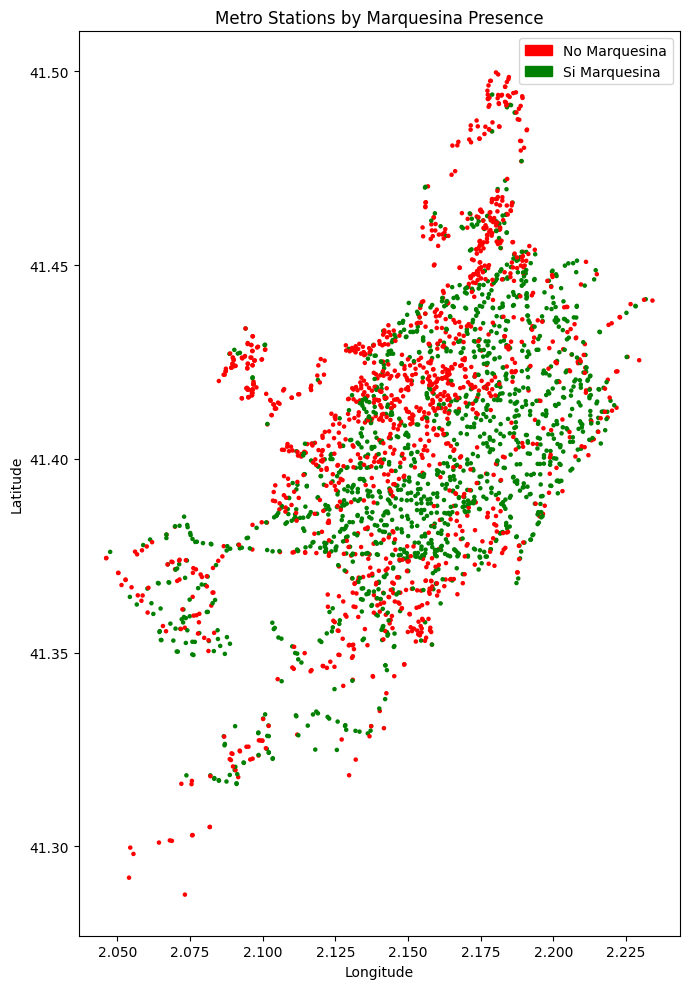

In [30]:
colors = ['red' if pd.isna(x) else 'green' for x in gdf['MARQUESINA']]

ax = gdf.plot(color=colors, figsize=(12, 10), markersize=5)
red_patch = mpatches.Patch(color='red', label='No Marquesina')
green_patch = mpatches.Patch(color='green', label='Si Marquesina')
plt.legend(handles=[red_patch, green_patch])
plt.title('Metro Stations by Marquesina Presence')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()


# Save data


In [31]:
gdf.to_crs(epsg=4326, inplace=True)  # Convert to WGS84 for GeoJSON compatibility
gdf.to_file(
    f"../data/IMPD_bus.geojson", driver='GeoJSON', index=False)
